# Advanced Pandas:  Summarizing data  

Another in a series of notebooks that describe Pandas' powerful data management tools.  In this one we summarize our data in a variety of ways.  Which is more interesting than it sounds.  

Outline:  

* [WEO government debt data](#weo).  Something to work with. How does Argentina's government debt compare to the debt of other countries?  How did it compare when it defaulted in 2001?  
* [Describing numerical data](#describe).  Descriptive statistics:  numbers of non-missing values, mean, median, quantiles.  
* [Describing catgorical data](#value-counts). The excellent `value_counts` method.  
* [Grouping data](#groupby).  An incredibly useful collection of tools based on grouping data based on a variable:  men and woman, grads and undergrads, and so on.  

**Note: requires internet access to run.**  

This Jupyter notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/).  

<a id=prelims></a>

## Preliminaries 

Import packages, etc.  

In [1]:
import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas 

%matplotlib inline                     

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Today: ', dt.date.today())

Python version: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.19.2
Today:  2017-04-25


<a id=weo></a>

## WEO data on government debt 

We use the IMF's data on government debt again, specifically its [World Economic Outlook database](https://www.imf.org/external/ns/cs.aspx?id=28), commonly referred to as the WEO.  We focus on government debt expressed as a percentage of GDP,  variable code `GGXWDG_NGDP`.   

The **central question** here is how the debt of Argentina, which defaulted in 2001, compared to other countries.  Was it a matter of too much debt or something else?  

### Load data

First step:  load the data and extract a single variable:  government debt (code `GGXWDG_NGDP`) expressed as a percentage of GDP.    

In [2]:
url = 'http://www.imf.org/external/pubs/ft/weo/2016/02/weodata/WEOOct2016all.xls'

weo = pd.read_csv(url, sep='\t', 
                  usecols=[1, 2] + list(range(19,46)), 
                  thousands=',', 
                  na_values=['n/a', '--']) 
print('Variable dtypes:\n', weo.dtypes.head(6), sep='')

Variable dtypes:
ISO                  object
WEO Subject Code     object
1990                float64
1991                float64
1992                float64
1993                float64
dtype: object


In [3]:
weo.head()

,ISO,WEO Subject Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,AFG,NGDP_R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,267.177,277.498,334.621,362.857,386.368,440.336,457.654,463.520,467.035,476.376
1,AFG,NGDP_RPCH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.340,3.863,20.585,8.438,6.479,13.968,3.933,1.282,0.758,2.000
2,AFG,NGDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,427.495,517.509,607.227,711.759,836.222,1033.591,1116.827,1167.905,1203.671,1283.049
3,AFG,NGDPD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.556,10.297,12.066,15.325,17.890,20.296,20.170,20.352,19.687,18.395
4,AFG,NGDP_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,160.005,186.491,181.467,196.154,216.432,234.728,244.033,251.964,257.726,269.336


### Clean and shape 

Second step:  select the variable we want and generate the two dataframes.  

In [4]:
# select debt variable 
variables = ['GGXWDG_NGDP']
db = weo[weo['WEO Subject Code'].isin(variables)]

# drop variable code column (they're all the same) 
db = db.drop('WEO Subject Code', axis=1)

# set index to country code 
db = db.set_index('ISO')

# name columns 
db.columns.name = 'Year'

# transpose 
dbt = db.T

# see what we have 
dbt.head()

ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,AUS,AUT,AZE,...,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB,ZWE
Year,,,,,,,,,,,,,,,,,,,,,
1990,NaN,NaN,NaN,NaN,98.071,NaN,NaN,16.455,56.057,NaN,...,28.821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,77.834,NaN,99.075,NaN,NaN,21.636,56.260,NaN,...,28.801,NaN,NaN,NaN,15.908,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,62.926,NaN,95.479,25.746,NaN,27.658,56.153,NaN,...,33.662,NaN,NaN,NaN,21.036,NaN,NaN,NaN,NaN,NaN
1993,NaN,NaN,74.028,NaN,90.147,27.739,NaN,30.660,60.765,NaN,...,38.531,NaN,NaN,NaN,20.274,NaN,NaN,NaN,NaN,NaN
1994,NaN,NaN,98.376,NaN,89.655,29.310,NaN,31.770,63.863,NaN,...,41.424,NaN,NaN,NaN,21.599,NaN,NaN,NaN,NaN,NaN


**Example.** Let's try a simple graph of the dataframe `dbt`.  The goal is to put Argentina in perspective by plotting it along with many other countries.  

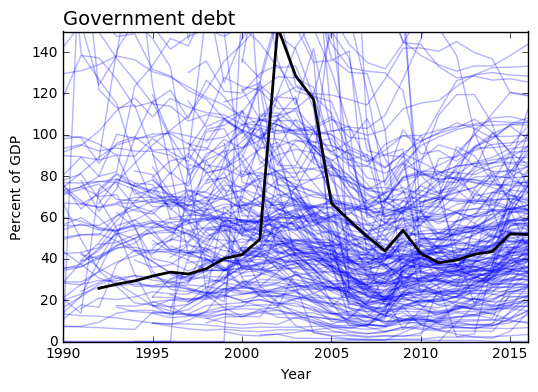

In [5]:
fig, ax = plt.subplots()
dbt.plot(ax=ax, 
         legend=False, color='blue', alpha=0.3, 
         ylim=(0, 150))

ax.set_ylabel('Percent of GDP')
ax.set_xlabel('')
ax.set_title('Government debt', fontsize=14, loc='left')
dbt['ARG'].plot(ax=ax, color='black', linewidth=2)

**Exercise.** 

* What do you take away from this graph?  
* What would you change to make it look better?
* To make it mnore informative?
* To put Argentina's debt in context?  

South America ISO codes?

Google search gives:

`http://www.countrycallingcodes.com/iso-country-codes/south-america-codes.php`

In [6]:
sa_iso = pd.read_html('http://www.countrycallingcodes.com/iso-country-codes/south-america-codes.php', header = 0,
                      attrs={"border": 1, "cellpadding": 3, "cellspacing": 0})[0]

In [7]:
sa_iso.columns = ['Country', 'iso2', 'iso3', 'domain']

In [8]:
countries = list(sa_iso['iso3'])

In [9]:
dbt_sa = db[db.index.isin(countries)].T

In [10]:
dbt_sa.head()

ISO,ARG,BOL,BRA,CHL,COL,ECU,GUY,PRY,PER,SUR,URY,VEN
Year,,,,,,,,,,,,
1990,NaN,NaN,NaN,43.635,NaN,NaN,NaN,67.003,NaN,78.038,NaN,NaN
1991,NaN,NaN,NaN,37.389,NaN,NaN,NaN,49.392,NaN,81.066,NaN,NaN
1992,25.746,NaN,NaN,30.641,NaN,NaN,NaN,34.390,NaN,68.943,NaN,NaN
1993,27.739,NaN,NaN,28.293,NaN,NaN,NaN,26.586,NaN,54.665,NaN,NaN
1994,29.310,NaN,NaN,22.830,NaN,NaN,NaN,18.691,NaN,32.656,NaN,NaN


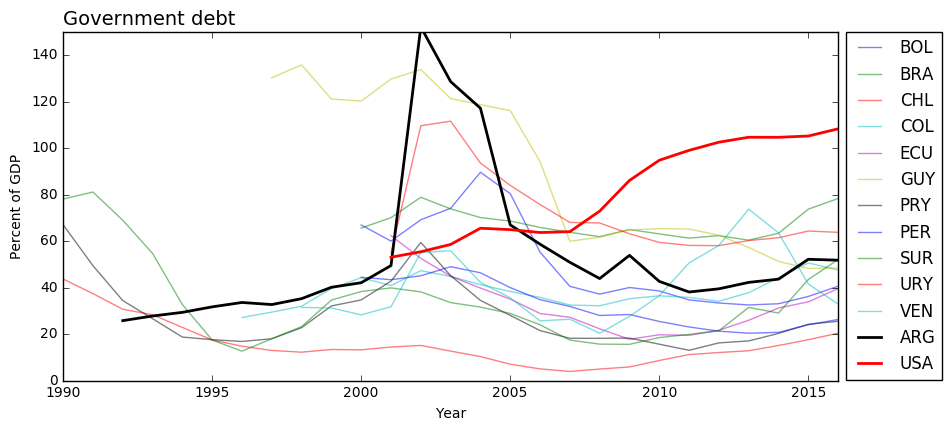

In [11]:
fig, ax = plt.subplots(figsize = (10, 4.5))

# skip ARG
dbt_sa.iloc[:, 1:].plot(ax=ax, alpha=0.5, ylim=(0, 150))

ax.set_ylabel('Percent of GDP')
ax.set_xlabel('')
ax.set_title('Government debt', fontsize=14, loc='left')
dbt['ARG'].plot(ax=ax, color='black', linewidth=2)
dbt['USA'].plot(ax=ax, color='red', linewidth=2)

# Put the legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<a id=describe></a>

## Describing numerical data 

Let's step back a minute.  What we're trying to do is compare Argentina to other countries.  What's the best way to do that?  This isn't a question with an obvious best answer, but we can try some things, see how they look.  One thing we could do is compare Argentina to the mean or median country.  Or to some other feature of the distribution.  

We work up to this by looking first at some features of the distribution of government debt numbers across countries.  Some of this we've seen, some is new.  

### What's (not) there?

Let's check out the data first.  How many non-missing values do we have at each date?   We can do that with the `count` method. The argument `axis=1` says to do this by date, counting across columns (axis number 1).  

In [12]:
dbt.shape

(27, 191)

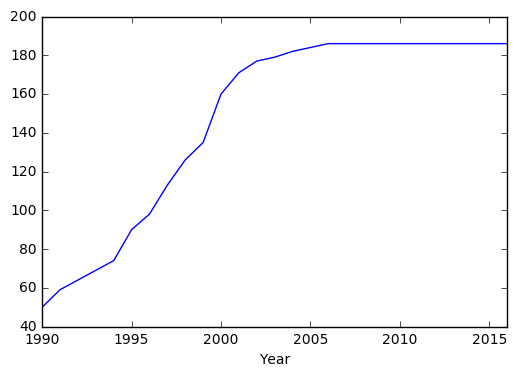

In [13]:
# count non-missing values 
dbt.count(axis='columns').plot()

### Describing series 

Let's take the data for 2001 -- the year of Argentina's default -- and see what how Argentina compares.  Was its debt high compare to other countries?  

which leads to more questions.  How would we compare?  Compare Argentina to the mean or median?  Something else?  

Let's see how that works.  

In [14]:
# 2001 data 
db01 = dbt.loc['2001'] 

In [15]:
# distribution of countries? histogram

#hist takes only non missing values
db01_nonan = db01[~db01.isnull()]

(array([ 10.,  23.,  32.,  37.,  14.,  11.,  18.,   7.,   6.,   2.,   2.,
          2.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   0.     ,   15.30565,   30.6113 ,   45.91695,   61.2226 ,
          76.52825,   91.8339 ,  107.13955,  122.4452 ,  137.75085,
         153.0565 ,  168.36215,  183.6678 ,  198.97345,  214.2791 ,
         229.58475,  244.8904 ,  260.19605,  275.5017 ,  290.80735,
         306.113  ,  321.41865,  336.7243 ,  352.02995,  367.3356 ,
         382.64125,  397.9469 ,  413.25255,  428.5582 ,  443.86385,
         459.1695 ,  474.47515,  489.7808 ,  505.08645,  520.3921 ,
         535.69775,  551.0034 ,  566.30905,  581.6147 ,  596.92035,  612.226  ]),
 <a list of 40 Patch objects>)

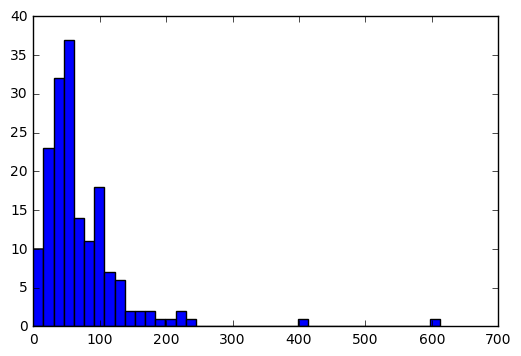

In [16]:
plt.hist(db01_nonan, bins=40)

In [17]:
db01['ARG']

49.436000000000007

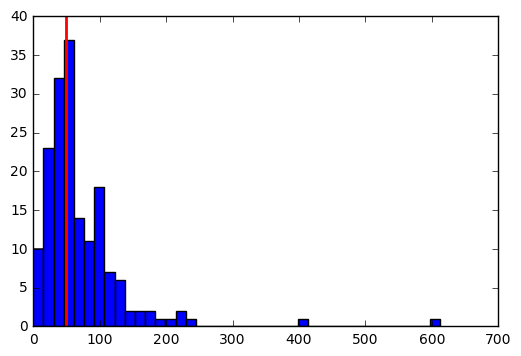

In [18]:
plt.hist(db01_nonan, bins=40)
plt.axvline(db01['ARG'], color = 'red', lw =2)

In [19]:
db01.mean()

70.95316374269008

In [20]:
db01.median()

55.042

In [21]:
db01.quantile(q=[0.25, 0.5, 0.75])

0.25    36.7330
0.50    55.0420
0.75    93.4185
Name: 2001, dtype: float64

(0, 250)

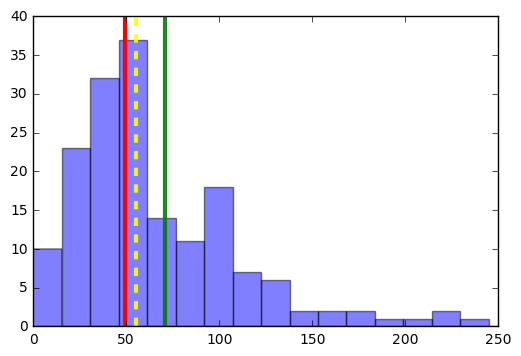

In [22]:
plt.hist(db01_nonan, bins=40, alpha = .5)
plt.axvline(db01['ARG'], color = 'red', lw =3)

plt.axvline(db01.mean(), color = 'green', alpha=.9, lw =3)
plt.axvline(db01.median(), color = 'yellow', alpha=.9, linestyle='--',lw =3)
plt.xlim([0, 250])

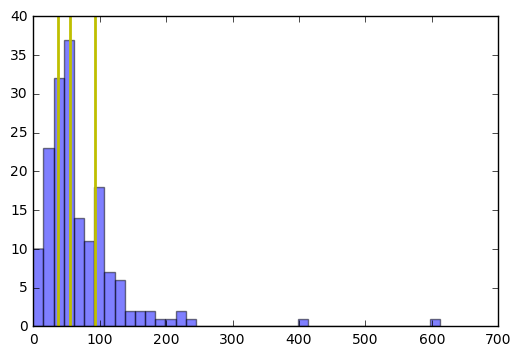

In [23]:
plt.hist(db01_nonan, bins=40, alpha = .5)
plt.axvline(db01.quantile(q=0.25), color = 'y', lw = 2)
plt.axvline(db01.quantile(q=0.5), color = 'y', lw = 2)
plt.axvline(db01.quantile(q=0.75), color = 'y', lw = 2)

In [24]:
db01.describe()

count    171.000000
mean      70.953164
std       66.124149
min        0.000000
25%       36.733000
50%       55.042000
75%       93.418500
max      612.226000
Name: 2001, dtype: float64

This looks a bit ugly. Let's make the figrue somewhat prettier. 

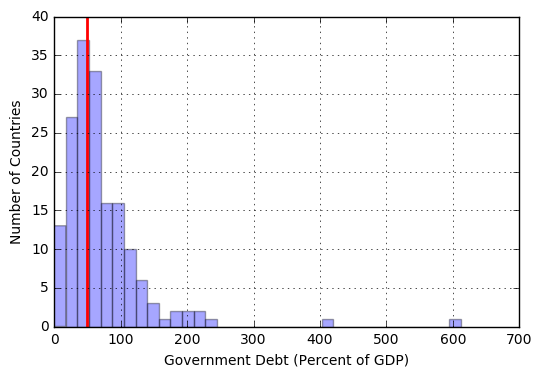

In [25]:
fig, ax = plt.subplots()
db01.hist(bins=35, ax=ax, alpha=0.35)
ax.set_xlabel('Government Debt (Percent of GDP)')
ax.set_ylabel('Number of Countries')

ymin, ymax = ax.get_ylim()
ax.vlines(db01['ARG'], ymin, ymax, color='red', lw=2) 

**Comment** Compared to the whole sample of countries in 2001, it doesn't seem that Argentina had particularly high debt. How about 2002?

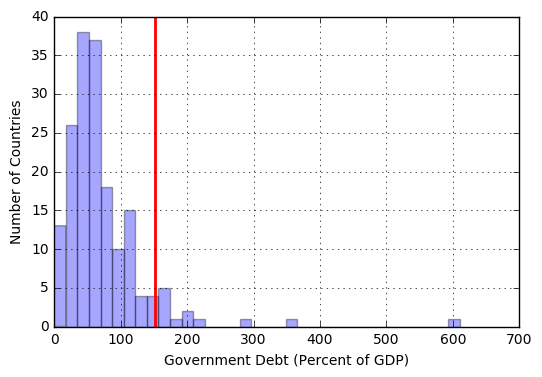

In [26]:
db02 = dbt.loc['2002'] 

fig, ax = plt.subplots()
db02.hist(bins=35, ax=ax, alpha=0.35)
ax.set_xlabel('Government Debt (Percent of GDP)')
ax.set_ylabel('Number of Countries')

ymin, ymax = ax.get_ylim()
ax.vlines(db02['ARG'], ymin, ymax, color='red', lw=2) 

### Describing dataframes

We can compute the same statistics for dataframes.  Here we have a choice:  we can compute (say) the mean down rows (`axis=0`) or across columns (`axis=1`).  If we use the dataframe `dbt`, computing the mean across countries (columns) calls for `axis=1`.

In [27]:
# here we compute the mean across countries at every date
dbt.mean(axis='columns')

Year
1990    66.182720
1991    65.216051
1992    68.962937
1993    67.588565
1994    68.204459
1995    60.579056
1996    55.993327
1997    56.468841
1998    58.299040
1999    59.566689
2000    67.897644
2001    70.953164
2002    71.630706
2003    70.079151
2004    67.070165
2005    60.450690
2006    52.344581
2007    46.220946
2008    44.210226
2009    46.761355
2010    46.060785
2011    46.346258
2012    47.560220
2013    49.205435
2014    51.105280
2015    54.197903
2016    56.037296
dtype: float64

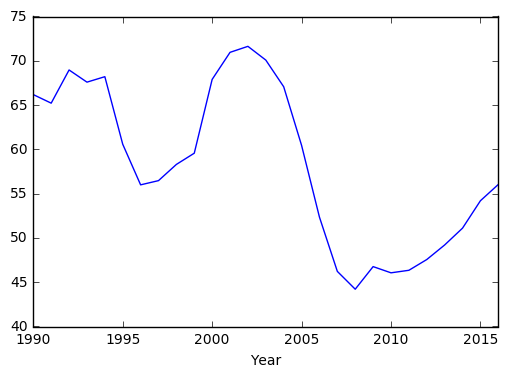

In [28]:
dbt.mean(axis='columns').plot()

In [29]:
# or we could do the median
dbt.median(axis='columns')

Year
1990    58.3170
1991    56.8560
1992    55.6240
1993    58.5990
1994    58.8295
1995    56.6150
1996    52.8160
1997    53.6960
1998    53.3315
1999    56.0390
2000    55.4675
2001    55.0420
2002    57.2150
2003    55.6430
2004    49.7555
2005    46.1280
2006    39.1455
2007    35.9875
2008    36.6555
2009    38.4645
2010    40.5780
2011    39.1395
2012    39.6135
2013    41.2650
2014    44.1135
2015    48.3485
2016    49.1075
dtype: float64

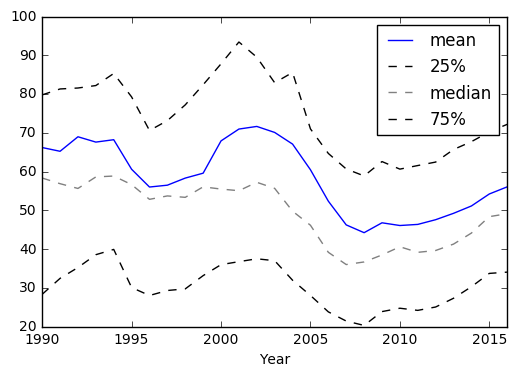

In [30]:
# changing distribution?
fig, ax = plt.subplots()
dbt.mean(axis='columns').plot(ax=ax, label='mean')

dbt.quantile(q=.25, axis='columns').plot(ax=ax, label='25%', color='k', linestyle='--')
dbt.median(axis='columns').plot(ax=ax, label='median', color='gray', linestyle='--')
dbt.quantile(q=.75, axis='columns').plot(ax=ax, label='75%', color='k', linestyle='--')
ax.legend(loc='best')

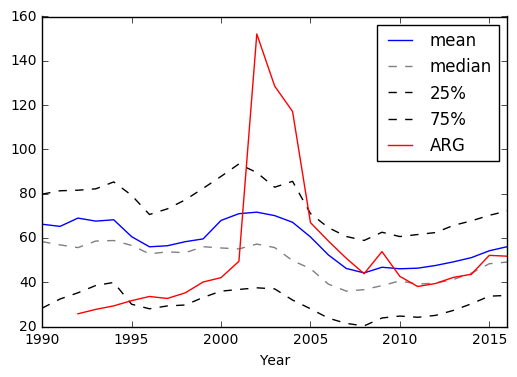

In [31]:
# changing distribution/ranking of ARG?
fig, ax = plt.subplots()
dbt.mean(axis='columns').plot(ax=ax, label='mean')
dbt.median(axis='columns').plot(ax=ax, label='median', color='gray', linestyle='--')
dbt.quantile(q=.25, axis='columns').plot(ax=ax, label='25%', color='k', linestyle='--')
dbt.quantile(q=.75, axis='columns').plot(ax=ax, label='75%', color='k', linestyle='--')
dbt['ARG'].plot(ax=ax, color='red')
ax.legend(loc='best')


Descriptive statistics in the country dimension

In [32]:
# or a bunch of stats at once 
# NB:  db not dbt (there's no axis argument here)
db.describe()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,50.000000,59.000000,64.000000,69.000000,74.000000,90.000000,98.000000,113.000000,126.000000,135.000000,...,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,66.182720,65.216051,68.962937,67.588565,68.204459,60.579056,55.993327,56.468841,58.299040,59.566689,...,46.220946,44.210226,46.761355,46.060785,46.346258,47.560220,49.205435,51.105280,54.197903,56.037296
std,54.539658,48.080837,62.333884,44.659771,52.224676,40.070138,37.242105,34.585702,38.200614,36.298899,...,46.697078,38.172559,34.076323,31.779981,33.071402,33.620635,34.263681,34.023216,32.927501,33.130111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.308750,32.421000,35.221000,38.531000,39.892500,30.056500,28.000000,29.290000,29.710000,33.128500,...,21.403750,20.276500,23.847750,24.716000,24.162000,25.030750,27.287750,30.262000,33.701750,34.032750
50%,58.317000,56.856000,55.624000,58.599000,58.829500,56.615000,52.816000,53.696000,53.331500,56.039000,...,35.987500,36.655500,38.464500,40.578000,39.139500,39.613500,41.265000,44.113500,48.348500,49.107500
75%,79.774250,81.301000,81.545500,82.180000,85.296000,79.249750,70.579750,73.130000,77.196250,82.387000,...,60.653000,58.854000,62.564000,60.613000,61.536000,62.433750,65.673000,67.708500,70.212250,72.170500
max,243.429000,203.364000,454.864000,262.608000,354.994000,219.552000,202.885000,156.196000,173.560000,164.268000,...,482.764000,309.661000,210.247000,215.821000,231.629000,238.015000,244.477000,249.114000,247.976000,250.350000


Descriptive statistics in the time dimension

In [33]:
# the other way 
dbt.describe()

ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,AUS,AUT,AZE,...,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB,ZWE
count,15.000000,20.000000,26.000000,17.000000,27.000000,25.00000,21.000000,27.000000,27.000000,22.000000,...,27.000000,16.000000,16.000000,19.000000,26.000000,19.000000,17.000000,18.000000,17.000000,12.000000
mean,75.207800,63.589350,44.182346,48.888529,99.262259,53.16564,34.701095,22.707593,69.702481,17.347045,...,51.730926,81.418187,72.070938,23.683368,25.293462,40.408053,43.745176,54.271000,26.800706,55.815167
std,110.734836,6.714871,34.284516,28.189135,13.291097,31.94029,10.606864,8.896043,9.343621,7.736943,...,21.155194,20.879053,18.128130,16.368927,6.669904,14.872159,9.079661,15.236932,11.789439,8.902903
min,6.246000,53.550000,7.744000,16.066000,77.271000,25.74600,14.249000,9.683000,56.057000,7.292000,...,28.801000,53.022000,54.890000,7.642000,15.908000,20.311000,31.432000,36.421000,16.718000,38.575000
25%,6.750000,58.082250,10.341750,29.487000,90.825000,35.20000,32.880000,15.759000,64.332500,12.412750,...,37.755500,63.920750,59.991000,10.358500,20.579000,29.712500,37.446000,44.282250,20.522000,51.336000
50%,16.776000,61.378500,38.795000,40.661000,97.698000,42.62400,37.824000,22.576000,66.484000,14.119500,...,41.642000,79.440500,64.008000,15.786000,22.552500,35.565000,40.897000,49.282000,21.932000,56.001500
75%,113.526500,70.802750,72.111000,68.692000,103.483500,52.13100,40.782000,29.987000,80.262500,22.584750,...,69.970000,103.024750,77.752500,32.250500,29.821250,52.801000,48.084000,59.883500,25.915000,59.972250
max,280.979000,73.321000,116.195000,104.542000,128.165000,152.11200,50.581000,40.943000,86.193000,39.578000,...,88.997000,108.249000,111.546000,59.375000,38.806000,73.702000,62.004000,96.050000,56.282000,68.864000


**Example.** Let's add the mean to our graph.  We make it a dashed line with `linestyle='dashed'`.  

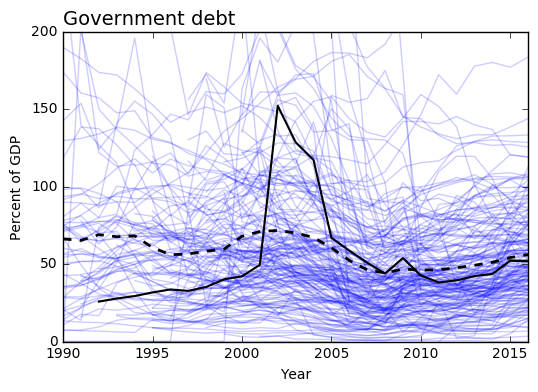

In [34]:
fig, ax = plt.subplots()
dbt.plot(ax=ax, 
         legend=False, color='blue', alpha=0.2, 
         ylim=(0,200)
        )
dbt['ARG'].plot(ax=ax, color='black', linewidth=1.5)
ax.set_ylabel('Percent of GDP')
ax.set_xlabel('')
ax.set_title('Government debt', fontsize=14, loc='left')
dbt.mean(axis=1).plot(ax=ax, color='black', linewidth=2, linestyle='dashed')

**Question.** Do you think this looks better when the mean varies with time, or when we use a constant mean?  Let's try it and see.  

In [35]:
dbar = dbt.mean().mean()
dbar

56.634779538782354

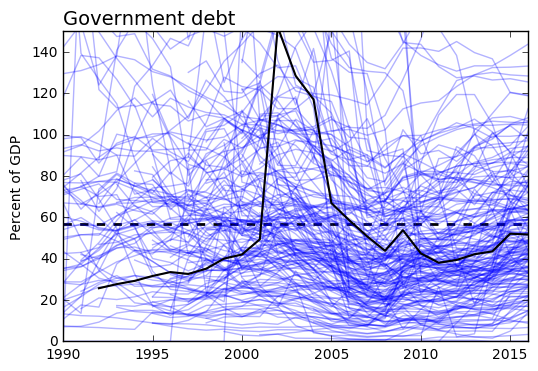

In [36]:
fig, ax = plt.subplots()
dbt.plot(ax=ax, 
         legend=False, color='blue', alpha=0.3, 
         ylim=(0,150)
        )
dbt['ARG'].plot(ax=ax, color='black', linewidth=1.5)
ax.set_ylabel('Percent of GDP')
ax.set_xlabel('')
ax.set_title('Government debt', fontsize=14, loc='left') 
xmin, xmax = ax.get_xlim()
ax.hlines(dbar, xmin, xmax, linewidth=2, linestyle='dashed')

**Exercise.** Which do we like better?

**Exercise.** Replace the (constant) mean with the (constant) median?  Which do you prefer?  

<a id=value-counts></a>

## Describing categorical data 

A **categorical variable** is one that takes on a small number of values.  States take on one of fifty values.  University students are either grad or undergrad.  Students select majors and concentrations.  

We're going to do two things with categorical data:  

* In this section, we count the number of observations in each category using the `value_counts` method. This is a series method, we apply it to one series/variable at a time.   
* In the next section, we go on to describe how other variables differ across catagories.  How do students who major in finance differ from those who major in English?  And so on.  

We start with the combined MovieLens data we constructed in the previous notebook.  

In [37]:
url = 'http://pages.stern.nyu.edu/~dbackus/Data/mlcombined.csv'
ml  = pd.read_csv(url, index_col=0)
print('Dimensions:', ml.shape)

Dimensions: (105339, 6)


In [38]:
ml.head()

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,1,24,1.5,1217895807,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,1217896246,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,1217896556,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,1217896523,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [39]:
# fix up the dates
ml["timestamp"] = pd.to_datetime(ml["timestamp"], unit="s")
ml.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,2008-08-05 00:56:33,Casino (1995),Crime|Drama
1,1,24,1.5,2008-08-05 00:23:27,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,2008-08-05 00:30:46,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,2008-08-05 00:35:56,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,2008-08-05 00:35:23,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,110,4.0,2008-08-05 00:29:10,Braveheart (1995),Action|Drama|War
6,1,150,3.0,2008-08-05 00:25:40,Apollo 13 (1995),Adventure|Drama|IMAX
7,1,161,4.0,2008-08-05 00:57:44,Crimson Tide (1995),Drama|Thriller|War
8,1,165,3.0,2008-08-05 00:45:35,Die Hard: With a Vengeance (1995),Action|Crime|Thriller
9,1,204,0.5,2008-08-05 00:23:06,Under Siege 2: Dark Territory (1995),Action


In [40]:
# which movies have the most ratings? 
ml['title'].value_counts().head(10)

Pulp Fiction (1994)                          325
Forrest Gump (1994)                          311
Shawshank Redemption, The (1994)             308
Jurassic Park (1993)                         294
Silence of the Lambs, The (1991)             290
Star Wars: Episode IV - A New Hope (1977)    273
Matrix, The (1999)                           261
Terminator 2: Judgment Day (1991)            253
Schindler's List (1993)                      248
Braveheart (1995)                            248
Name: title, dtype: int64

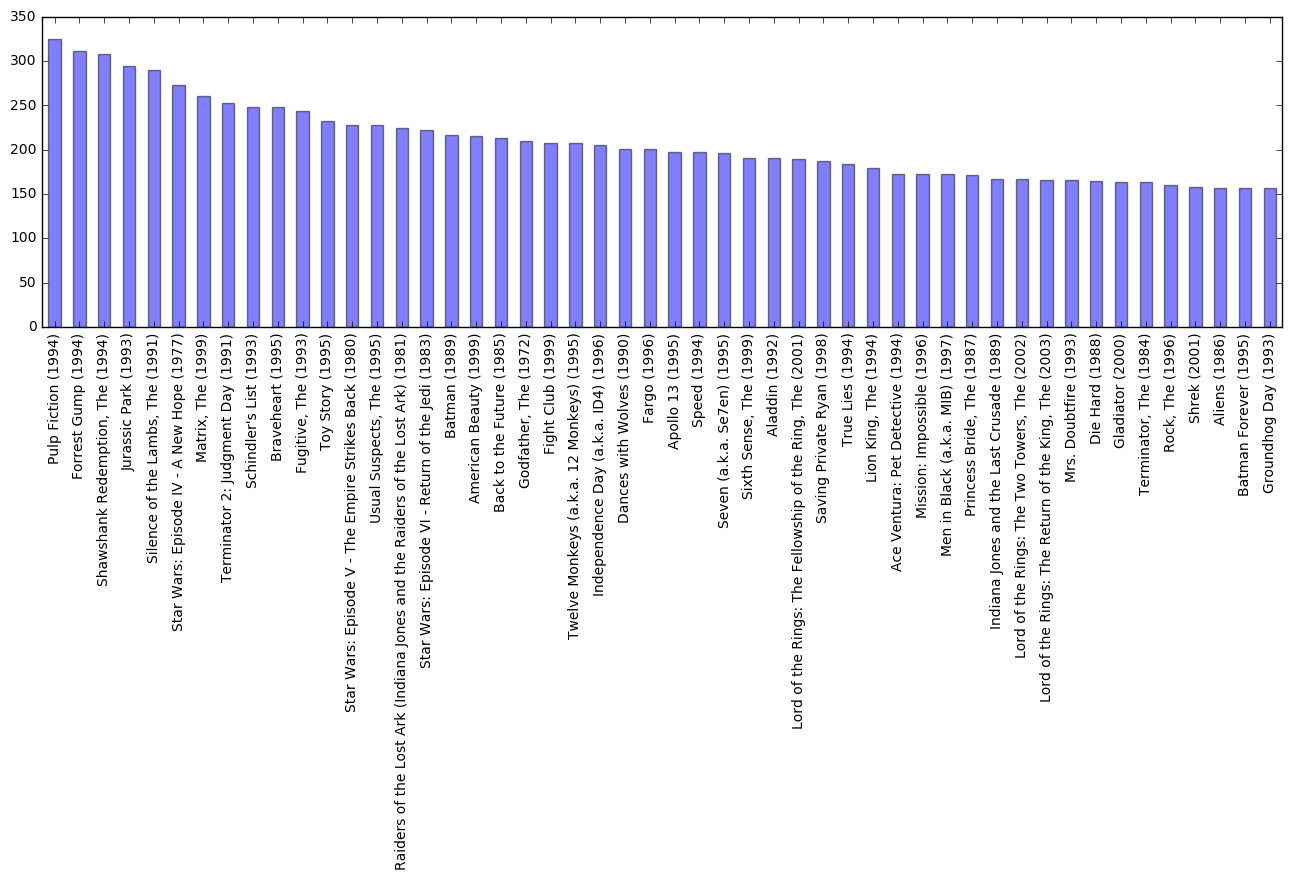

In [42]:
ml['title'].value_counts().head(50).plot(kind='bar', alpha=0.5, figsize=(16, 4))

In [43]:
# which people have rated the most movies?
ml['userId'].value_counts().head(10)

668    5678
575    2837
458    2086
232    1421
310    1287
475    1249
128    1231
224    1182
607    1176
63     1107
Name: userId, dtype: int64

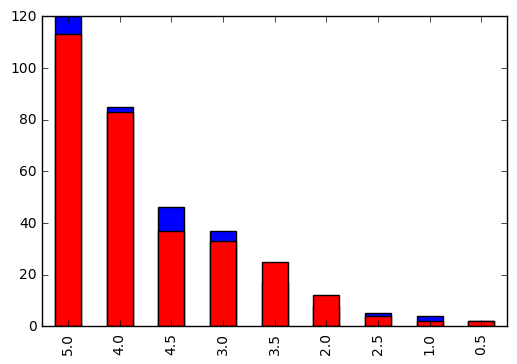

In [44]:
ml['rating'][ml['title']== 'Pulp Fiction (1994)'].value_counts().plot(kind='bar')
ml['rating'][ml['title']== 'Forrest Gump (1994)'].value_counts().plot(kind='bar', color='red')

<a id=groupby></a>

## Grouping data 

Next up:  group data by some variable.  As an example, how would we compute the average rating of each movie?  If you think for a minute, you might think of these steps:

* Group the data by movie:  Put all the "Pulp Fiction" ratings in one bin, all the "Shawshank" ratings in another.  We do that with the `groupby` method. 
* Compute a statistic (the mean, for example) for each group.  

Pandas has tools that make that relatively easy.  

In [45]:
# group 
g = ml.groupby('title')
type(g)

pandas.core.groupby.DataFrameGroupBy

Now that we have a groupby object, what can we do with it?  

In [46]:
# the number in each category
g.count()

,userId,movieId,rating,timestamp,genres
title,,,,,
'71 (2014),1,1,1,1,1
'Hellboy': The Seeds of Creation (2004),1,1,1,1,1
'Round Midnight (1986),1,1,1,1,1
'Til There Was You (1997),3,3,3,3,3
"'burbs, The (1989)",20,20,20,20,20
'night Mother (1986),1,1,1,1,1
(500) Days of Summer (2009),37,37,37,37,37
*batteries not included (1987),11,11,11,11,11
...And Justice for All (1979),10,10,10,10,10


In [47]:
# what type of object have we created?
type(g.count())

pandas.core.frame.DataFrame

**Comment.** Note that the combination of `groupby` and `count` created a dataframe with

* Its index is the variable we grouped by.  If we group by more than one, we get a multi-index.
* Its columns are the other variables.  



In [48]:
gm = g['rating'].mean()
gm.head()

title
'71 (2014)                                 3.500
'Hellboy': The Seeds of Creation (2004)    3.000
'Round Midnight (1986)                     2.500
'Til There Was You (1997)                  4.000
'burbs, The (1989)                         3.125
Name: rating, dtype: float64

In [49]:
# how many ratings?
grouped = g.count()
grouped = grouped.rename(columns={'rating': 'Number'})   

# average rating?
grouped['Mean'] = g['rating'].mean()
grouped.head(10)

,userId,movieId,Number,timestamp,genres,Mean
title,,,,,,
'71 (2014),1,1,1,1,1,3.500000
'Hellboy': The Seeds of Creation (2004),1,1,1,1,1,3.000000
'Round Midnight (1986),1,1,1,1,1,2.500000
'Til There Was You (1997),3,3,3,3,3,4.000000
"'burbs, The (1989)",20,20,20,20,20,3.125000
'night Mother (1986),1,1,1,1,1,3.000000
(500) Days of Summer (2009),37,37,37,37,37,3.932432
*batteries not included (1987),11,11,11,11,11,3.318182
...And Justice for All (1979),10,10,10,10,10,3.650000


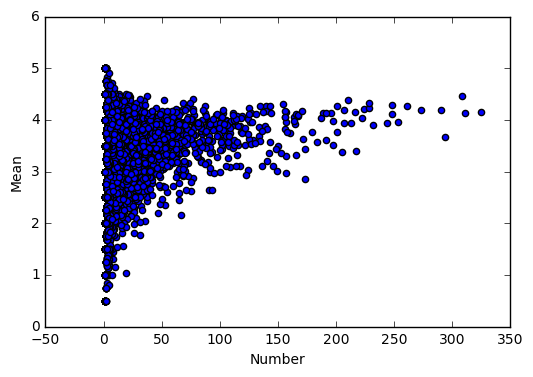

In [50]:
grouped.plot.scatter(x='Number', y='Mean')

**Exercise.** Compute the median and add it to the dataframe.  

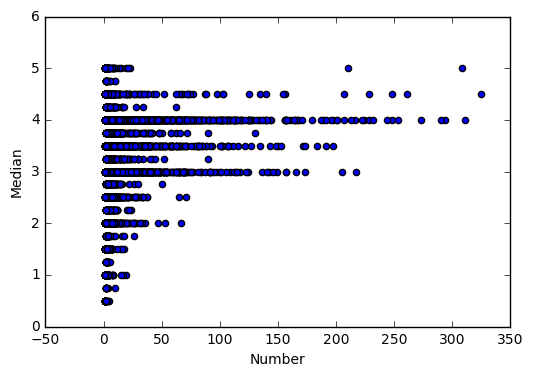

In [51]:
grouped['Median'] = g['rating'].median()
grouped.plot.scatter(x='Number', y='Median')


#### Multi-index

In [52]:
ml.head()

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,2008-08-05 00:56:33,Casino (1995),Crime|Drama
1,1,24,1.5,2008-08-05 00:23:27,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,2008-08-05 00:30:46,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,2008-08-05 00:35:56,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,2008-08-05 00:35:23,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [53]:
mean_rating = ml.groupby(['userId', 'title']).mean()
mean_rating['rating'].head()

userId  title                    
1       American Beauty (1999)       4.0
        Animal House (1978)          4.5
        Apollo 13 (1995)             3.0
        Back to the Future (1985)    3.0
        Batman (1989)                2.5
Name: rating, dtype: float64

In [57]:
mean_rating.head()

movieId  rating
userId title                                     
1      American Beauty (1999)      2858.0     4.0
       Animal House (1978)         3421.0     4.5
       Apollo 13 (1995)             150.0     3.0
       Back to the Future (1985)   1270.0     3.0
       Batman (1989)                592.0     2.5

In [58]:
mean_rating.index.get_level_values('userId')==100

array([False, False, False, ..., False, False, False], dtype=bool)

In [59]:
mean_rating['rating'].iloc[mean_rating.index.get_level_values('userId')==100]

userId  title                                                                                         
100     Apollo 13 (1995)                                                                                  5.0
        Back to the Future Part III (1990)                                                                3.0
        Bastard Out of Carolina (1996)                                                                    2.5
        Beautiful Mind, A (2001)                                                                          4.0
        Blade (1998)                                                                                      5.0
        Blair Witch Project, The (1999)                                                                   0.5
        Bug's Life, A (1998)                                                                              3.0
        Cable Guy, The (1996)                                                                             3.5
        Casper (1

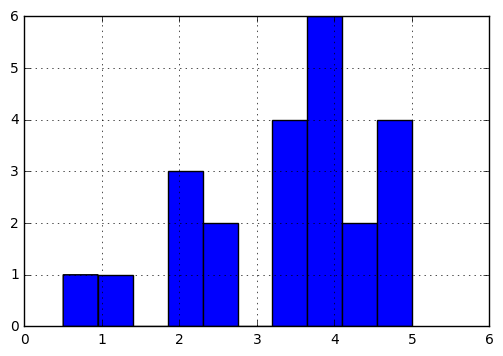

In [60]:
mean_rating['rating'].iloc[mean_rating.index.get_level_values('userId')==10].hist()

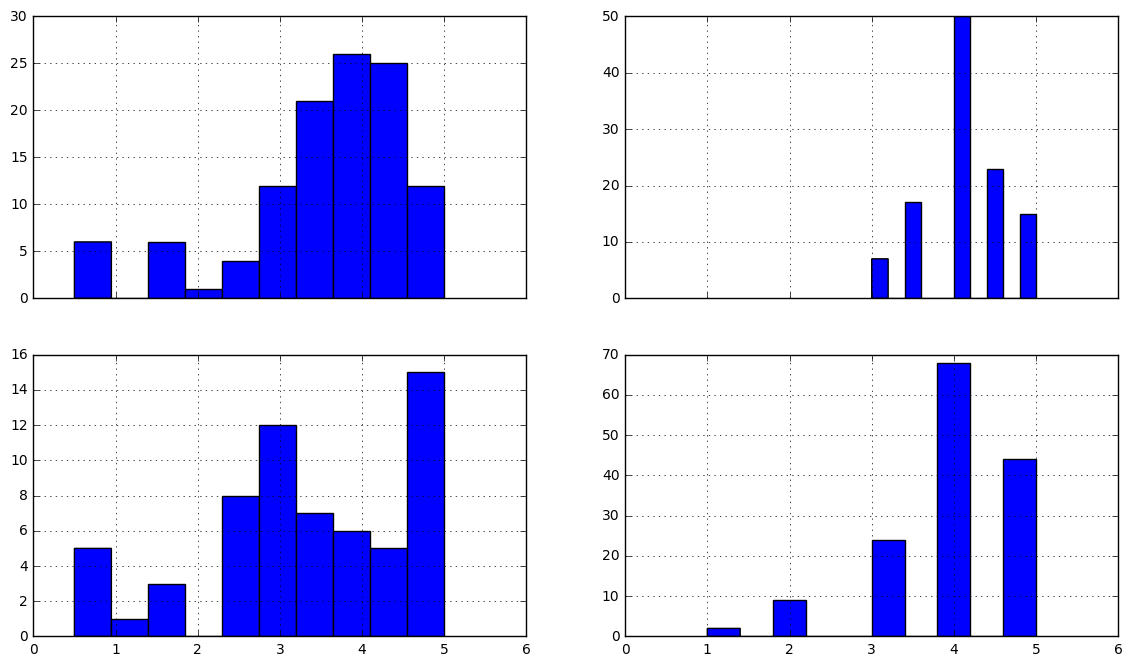

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
mean_rating['rating'].iloc[mean_rating.index.get_level_values('userId')==1].hist(ax=ax[0,0])
mean_rating['rating'].iloc[mean_rating.index.get_level_values('userId')==97].hist(ax=ax[0,1])
mean_rating['rating'].iloc[mean_rating.index.get_level_values('userId')==100].hist(ax=ax[1,0])
mean_rating['rating'].iloc[mean_rating.index.get_level_values('userId')==210].hist(ax=ax[1,1])

## Resources

The [Brandon Rhodes video](https://youtu.be/5JnMutdy6Fw) covers most of this, too.  